In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/My Drive/agri_data')
os.getcwd()

'/content/gdrive/My Drive/agri_data'

In [3]:
path = '/content/gdrive/My Drive/agri_data'
files = os.listdir(path)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense

In [22]:
data_dir = '/content/gdrive/My Drive/agri_data/data'
shape = 224
classes = []

class Data:
    def __init__(self,shape,data_dir):
        self.data = os.listdir(data_dir)
        self.data_csv = 0
        self.image_data = []
        self.y_bbox = []
        self.label_data = []
        self.image_data_files = []
        self.label_data_files = []
        self.labels = []
        self.shape = shape
        self.data_dir = data_dir
        
    def image_preprocessing(self,path):
        image = cv2.imread(path)
        image = cv2.resize(image, (shape,shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.reshape(image,(shape,shape,3))
        image = np.array(image, dtype = 'float32')
        image /= 255.
        return image 
    
    def image_and_label_data(self):
        for data_file in self.data:
            if data_file.split('.')[-1] == 'txt':
                data = open(f'{self.data_dir}/{data_file}', 'r').readline().split()
                
                df = pd.DataFrame()
                df['filename'] = [data_file]
                df['class'] = [float(data[0])]
                df['xmin'] = [float(data[1])]
                df['ymin'] = [float(data[2])]
                df['xmax'] = [float(data[3])]
                df['ymax'] = [float(data[4])]
                self.label_data_files.append(df)
                
        self.data_csv = pd.concat(self.label_data_files)
        for i in list(self.data_csv.columns[2:]):
            self.data_csv[i] = self.data_csv[i].astype(float)
            
    def read_images(self):
        self.image_paths = self.data_csv['filename'].values
        for image in self.image_paths:
            self.image_data.append(self.image_preprocessing(self.data_dir + '/' +image.split('.')[0] + '.jpeg'))
                
    def read_labels(self):
        global classes
        self.classes = self.data_csv['class'].unique().tolist()
        classes = self.classes
        self.label_data = self.data_csv['class'].values
        self.label_data = [self.classes.index(i) for i in self.label_data]
        self.label_data = tf.keras.utils.to_categorical(self.label_data)
        self.label_data = np.array(self.label_data,dtype = 'float32')
    
    def bboxes(self):
        for index, _ in enumerate(self.data_csv["xmin"].values):
            self.y_bbox.append(self.data_csv.iloc[[index]].values[0])
        self.y_bbox = np.array(self.y_bbox, dtype= "float32")
        

        
    def load_data(self):
        self.image_and_label_data()
        self.read_labels()
        self.read_images()
        self.data_csv = self.data_csv.drop('class',axis = 1)
        self.data_csv = self.data_csv.drop('filename',axis=1)
        self.bboxes()
            
        return train_test_split(self.image_data,self.label_data,self.y_bbox,random_state = 43,shuffle=True)
                               
         

In [23]:
data = Data(shape,data_dir)
#r = data.read_images()
split = data.load_data()

In [24]:
(X_train, X_test) = split[:2]
(y_train,y_test) = split[2:4]
(y_bbox_train, y_bbox_test) = split[4:]
X_train = np.array(X_train, dtype = 'float32')
X_test = np.array(X_test, dtype = 'float32')

y_bbox_train = np.array(y_bbox_train, dtype ='float32')
y_bbox_test = np.array(y_bbox_test, dtype = 'float32')
y_train = np.array(y_train, dtype = 'float32')
y_test = np.array(y_test, dtype = 'float32')

print(f'X_train of Shape: {X_train.shape}')
print(f'X_test of Shape : {X_test.shape}')
print(f'y_train of Shape : {y_train.shape}')
print(f'y_test of Shape : {y_test.shape}')
print(f'y_bbox_train of Shape: {y_bbox_train.shape}')
print(f'y_bbox_test of Shape: {y_bbox_test.shape}')


X_train of Shape: (975, 224, 224, 3)
X_test of Shape : (325, 224, 224, 3)
y_train of Shape : (975, 2)
y_test of Shape : (325, 2)
y_bbox_train of Shape: (975, 4)
y_bbox_test of Shape: (325, 4)


In [25]:
class NN():
    def __init__(self, cnn):
        self.model_input_lr = Input(shape=(shape,shape,3))
        self.cnn = cnn(weights = 'imagenet',include_top=False, input_tensor = self.model_input_lr)
        for layer in self.cnn.layers:
            layer.trainable = False
        self.model_build()
    

    def model_build(self):
        flatten = Flatten()(self.cnn.output)
        x = Dense(512,activation='relu',kernel_initializer='he_normal')(flatten)
        x = Dense(256,activation='relu',kernel_initializer='he_normal')(x)
   
        x = Dense(128,activation='relu',kernel_initializer='he_normal')(x)

        output1 = Dense(len(classes),activation='softmax',name='classification_lr')(x)
        
        x = Dense(256,activation='relu',kernel_initializer='he_normal')(flatten)
        x = Dense(128,activation='relu',kernel_initializer='he_normal')(x)
        x = Dense(64,activation='relu',kernel_initializer='he_normal')(x)
        x = Dense(32,activation='relu',kernel_initializer='he_normal')(x)
        output2 = Dense(4,activation='sigmoid',name='boundingbox')(x)
        
        optimizer = tf.keras.optimizers.Adam(1e-4)
        self.model = Model(inputs = [self.model_input_lr],outputs=[output1,output2])
        losses = {'classification_lr':'categorical_crossentropy','boundingbox':'mean_squared_error'}
        lossWeights ={'classification_lr' :1., 'boundingbox':1.}
        self.model.compile(optimizer=optimizer,loss =losses,metrics=['accuracy'])
        
        self.model.fit(X_train,y ={'classification_lr':y_train,'boundingbox':y_bbox_train},epochs=50,batch_size=16,validation_data=(X_test,{'classification_lr':y_test,'boundingbox':y_bbox_test}),shuffle=True)
        

In [26]:
model = NN(tf.keras.applications.vgg19.VGG19)

Epoch 1/50
61/61 [==============================] - 29s 364ms/step - loss: 0.2666 - classification_lr_loss: 0.2456 - boundingbox_loss: 0.0210 - classification_lr_accuracy: 0.9149 - boundingbox_accuracy: 0.5651 - val_loss: 0.1400 - val_classification_lr_loss: 0.1265 - val_boundingbox_loss: 0.0134 - val_classification_lr_accuracy: 0.9662 - val_boundingbox_accuracy: 0.6338
Epoch 2/50
61/61 [==============================] - 14s 229ms/step - loss: 0.1245 - classification_lr_loss: 0.1154 - boundingbox_loss: 0.0091 - classification_lr_accuracy: 0.9641 - boundingbox_accuracy: 0.6821 - val_loss: 0.1653 - val_classification_lr_loss: 0.1544 - val_boundingbox_loss: 0.0109 - val_classification_lr_accuracy: 0.9692 - val_boundingbox_accuracy: 0.6769
Epoch 3/50
61/61 [==============================] - 14s 228ms/step - loss: 0.1203 - classification_lr_loss: 0.1138 - boundingbox_loss: 0.0065 - classification_lr_accuracy: 0.9610 - boundingbox_accuracy: 0.7415 - val_loss: 0.2592 - val_classification_lr_l

[[0. 1.]]


(-0.5, 223.5, 223.5, -0.5)

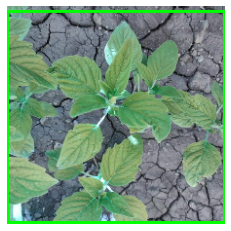

In [28]:
image = cv2.imread("/content/gdrive/My Drive/agri_data/data/agri_0_544.jpeg")
image = cv2.resize(image, (shape, shape))
image_1 = np.reshape(image, (1 ,shape, shape, 3))
pred = model.model.predict(image_1)
print(pred[0])
startX = int(pred[1][0][0] * 224)
startY = int(pred[1][0][1] * 224)
endX =   int(pred[1][0][2] * 224)
endY =   int(pred[1][0][3] * 224)
cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
plt.imshow(image)
plt.axis('off')